Making plots for the presentation
-------------------

In [47]:
import numpy as np
import rank
import matplotlib.pyplot as plt
import networkx as nx
import scipy
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.stats import spearmanr
import math
%matplotlib inline

ModuleNotFoundError: No module named 'community'

Plots for Intuition
--------

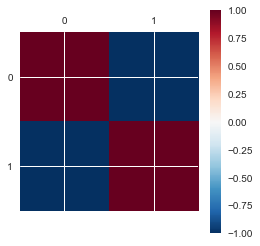

In [103]:
C = np.array([[0,1],[0,0]])
cor = rank.pearson_correlation(rank.spring_rank(C)[1])
plt.matshow(cor, cmap='RdBu_r');
plt.colorbar();
plt.savefig('presentation/images/intuition/2nodes.png')

In [20]:
n = 7
m = 20
A = np.array([[0,1,1,0,0,0,0],
             [0,0,1,1,0,0,0],
             [0,0,0,1,0,0,0],
             [0,0,0,0,0,0,0],
             [0,0,0,0,0,1,0],
             [0,0,0,0,1,0,1],
             [0,0,0,0,1,0,0]])
weights = np.arange(m)+1
i_add = np.array([2,3,4,5,3])
j_add = np.array([4,4,1,3,6])
standard_deviation = np.zeros((n,m))
rankings = np.zeros((n,m))
correlation_w = np.zeros((m,n,n))
correlation_c = np.zeros((i_add.size,n,n))

In [21]:
#looking at correlation as connections between two components increases
for k in range(i_add.size):
    A[i_add[k], j_add[k]] = 1
    out = rank.spring_rank(A)
    correlation_c[k,:,:] = rank.pearson_correlation(out[1])

In [22]:
#looking at rankings, std, and correlation as weight of an edge increases
for i in range(m):
    w = weights[i]
    A[2,3] = w
    out = rank.spring_rank(A)
    rankings[:,i] = out[0]
    correlation_w[i,:,:] = rank.pearson_correlation(out[1])
    standard_deviation[:,i] = np.sqrt(np.diag(out[1]))

In [11]:
np.savez('presentation/intuition_example_data.npz', std = standard_deviation, rankings = rankings, 
         correlation_w = correlation_w, correlation_c = correlation_c)

In [23]:
#Plot two components
for k in range(i_add.size):
    plt.matshow(correlation_c[k,:,:], cmap='RdBu_r');
    plt.colorbar();
    plt.savefig('presentation/images/intuition/G1_'+str(i_add[k])+str(j_add[k])+'.png')
    plt.clf()

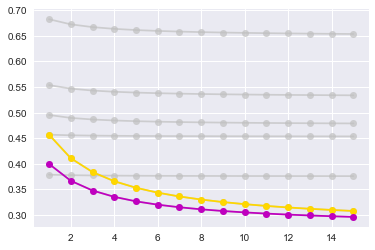

In [36]:
#Plot weight increases vs standard deviation
plt.plot(weights[:15], standard_deviation[:,:15].T, marker='o', color='silver', alpha=0.7);
plt.plot(weights[:15], standard_deviation[2,:15].T, marker='o', color='gold');
plt.plot(weights[:15], standard_deviation[3,:15].T, marker='o', color='m');
plt.savefig('presentation/images/intuition/std.png')

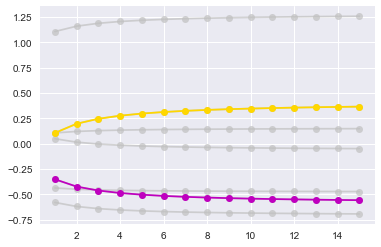

In [39]:
#Plot weight increases vs rankings
plt.plot(weights[:15], rankings[:,:15].T, marker='o', color='silver', alpha=0.7);
plt.plot(weights[:15], rankings[2,:15].T, marker='o', color='gold');
plt.plot(weights[:15], rankings[3,:15].T, marker='o', color='m');
plt.savefig('presentation/images/intuition/rankings.png')

In [41]:
#Plot correlation with weights
for w in range(15):
    plt.matshow(correlation_w[w,:,:], cmap='RdBu_r');
    plt.colorbar();
    plt.savefig('presentation/images/intuition/G1_w'+str(weights[w])+'.png')
    plt.clf()

Y Graph with different trunk length
------------

In [135]:
colors_list = ['r','g','b','c','m','y','k','w']
trunk_lengths = np.arange(1,100,10)
n = 101 
reps = 1
trials = 6

beta_hat_list = np.zeros((trunk_lengths.size, reps))
c_hat_list = np.zeros((trunk_lengths.size, reps))

homogeneity = np.zeros((trunk_lengths.size, reps)) #using delta correlation
completeness = np.zeros((trunk_lengths.size, reps))
vmeasure = np.zeros((trunk_lengths.size, reps))

homogeneity2 = np.zeros((trunk_lengths.size, reps)) #using just correlation
completeness2 = np.zeros((trunk_lengths.size, reps))
vmeasure2 = np.zeros((trunk_lengths.size, reps))

homogeneity3 = np.zeros((trunk_lengths.size, reps)) #using just rankings
completeness3 = np.zeros((trunk_lengths.size, reps))
vmeasure3 = np.zeros((trunk_lengths.size, reps))

homogeneity4 = np.zeros((trunk_lengths.size, reps)) #using partition on the network
completeness4 = np.zeros((trunk_lengths.size, reps))
vmeasure4 = np.zeros((trunk_lengths.size, reps))


correlations_A = np.zeros((trunk_lengths.size,n,n))
correlations_B = np.zeros((trunk_lengths.size,n,n))
delta_correlations = np.zeros((trunk_lengths.size,n,n))

scores_Graph_As = np.zeros((trunk_lengths.size, n))
scores_Graph_Bs = np.zeros((trunk_lengths.size, n))

In [136]:
# Manually make Y graph
for t in range(trunk_lengths.size):
    trunk_length = trunk_lengths[t]
    
    Graph_A = np.zeros((n,n))
    # make Y graph
    start_snd_branch =  int(trunk_length + (n-trunk_length)/2)
    for i in range(start_snd_branch-1):
        Graph_A[i+1, i] = 1
    Graph_A[start_snd_branch, trunk_length] = 1
    for j in range(start_snd_branch, n-1):
        Graph_A[j+1, j] = 1
        
    groups = np.concatenate((np.repeat(0, trunk_length), np.repeat(1, (n-trunk_length)/2), np.repeat(2, (n-trunk_length)/2)))
    
    avg_degree = np.sum(Graph_A)/n
    out = rank.spring_rank(Graph_A)
    scores_Graph_A = out[0]
    sigma_Graph_A = out[1]
    correlation_A = rank.pearson_correlation(sigma_Graph_A)
    correlations_A[t,:,:] = correlation_A
    scores_Graph_As[t,:] = scores_Graph_A
    
    for r in range(reps):
#         n_clusters = 3 #When we know true number of clutser
        
        #Using just correlation:
        #choose number of cluster using silhouette scores:
        ss = np.zeros(trials)
        for k in range(1,trials):
            kmeans = KMeans(n_clusters=k+1, random_state=0).fit(correlation_A)
            ss[k] = metrics.silhouette_score(correlation_A, kmeans.labels_)
        n_clusters = int(np.argmax(ss) + 1)
        
        #cluster
        kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(correlation_A)
        groups_pred = kmeans.labels_
        homogeneity2[t, r] = metrics.homogeneity_score(groups, groups_pred)  
        completeness2[t, r] = metrics.completeness_score(groups, groups_pred)
        vmeasure2[t, r] = metrics.v_measure_score(groups, groups_pred)
        
        
        #Using the rankings:
        ss = np.zeros(trials)
        for k in range(1,trials):
            kmeans = KMeans(n_clusters=k+1, random_state=0).fit(scores_Graph_A.reshape((n,1)))
            ss[k] = metrics.silhouette_score(scores_Graph_A.reshape((n,1)), kmeans.labels_)
        n_clusters = int(np.argmax(ss) + 1)
        
        #cluster
        kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(scores_Graph_A.reshape((n,1)))
        groups_pred = kmeans.labels_
        homogeneity3[t, r] = metrics.homogeneity_score(groups, groups_pred)  
        completeness3[t, r] = metrics.completeness_score(groups, groups_pred)
        vmeasure3[t, r] = metrics.v_measure_score(groups, groups_pred)
        
        #Using delta correlation
        beta_hat = rank.estimate_beta(Graph_A, scores_Graph_A) #MLE of beta and c from Y graph
        c_hat = rank.estimate_c(avg_degree, beta_hat, scores_Graph_A)
        beta_hat_list[t, r] = beta_hat
        c_hat_list[t,r] = c_hat

        #Create null model of Y graph
        Graph_B = rank.generate_graph2(scores_Graph_A, beta_hat, c_hat)
        out = rank.spring_rank(Graph_B)
        scores_Graph_B = out[0]
        sigma_Graph_B = out[1]
        correlation_B = rank.pearson_correlation(sigma_Graph_B)

        delta_correlation = correlation_B - correlation_A
        
        if r==0:
            correlations_B[t,:,:] = correlation_B
            delta_correlations[t,:,:] = delta_correlation
            scores_Graph_Bs[t,:] = scores_Graph_B

        #choose number of cluster using silhouette scores:
        ss = np.zeros(trials)
        for k in range(1,trials):
            kmeans = KMeans(n_clusters=k+1, random_state=0).fit(delta_correlation)
            ss[k] = metrics.silhouette_score(delta_correlation, kmeans.labels_)
        n_clusters = int(np.argmax(ss) + 1)
        #cluster
        kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(delta_correlation)
        groups_pred = kmeans.labels_
        homogeneity[t, r] = metrics.homogeneity_score(groups, groups_pred)  
        completeness[t, r] = metrics.completeness_score(groups, groups_pred)
        vmeasure[t, r] = metrics.v_measure_score(groups, groups_pred)
        
        

C:\Users\Phuc\Documents\MACALESTER\JUNIOR\Summer\SFI2017\springrank\rank.py:196: RuntimeWarning: overflow encountered in exp
  p = (1 + np.exp(-2 * beta * d))**(-1)
C:\Users\Phuc\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:161: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


In [133]:
#CAREFULL! DON'T OVERWRITE FILES!!!
# np.savez('y_graph_data_8-6.npz', beta_hats=beta_hat_list, c_hats=c_hat_list,
#         delta_homogeneity=homogeneity, delta_completeness=completeness, delta_vmeasure=vmeasure,
#         cor_homogeneity=homogeneity2, cor_completeness=completeness2, cor_vmeasure=vmeasure2,
#         scr_homogeneity=homogeneity3, scr_completeness=completeness3, scr_vmeasure=vmeasure3,
#         correlation_A=correlations_A, correlation_B=correlations_B, delta_correlation=delta_correlations,
#         scores_A=scores_Graph_As, scores_B=scores_Graph_Bs)

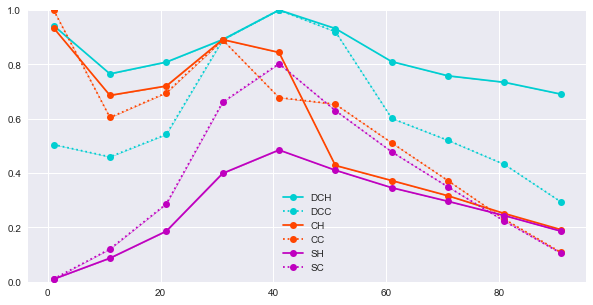

In [137]:
#Plot clustering homogeneity and completeness for delta_correl, correlation, and ranks
#source https://stackoverflow.com/questions/21654635/scatter-plots-in-pandas-pyplot-how-to-plot-by-category
#error band: https://stackoverflow.com/questions/12957582/matplotlib-plot-yerr-xerr-as-shaded-region-rather-than-error-bars


reps=1
colors = ['darkturquoise','orangered','m','greenyellow']
homos = [homogeneity, homogeneity2, homogeneity3]
coms = [completeness, completeness2, completeness3]
labels =[('DCH','DCC'),('CH','CC'),('SH','SC')]
f, ax = plt.subplots(figsize=(10,5))
ax.margins(0.05)
for i in range(len(homos)):
    error1=np.std(homos[i], axis=1)/math.sqrt(1)
    error2=np.std(coms[i], axis=1)/math.sqrt(1)
    ax.plot(trunk_lengths, np.mean(homos[i], axis=1), marker='o', label=labels[i][0], color=colors[i])
    ax.plot(trunk_lengths, np.mean(coms[i], axis=1), marker='o', ls='dotted', label=labels[i][1], color=colors[i])
    plt.fill_between(trunk_lengths, np.mean(homos[i], axis=1)-error1, np.mean(homos[i], axis=1)+error1, alpha=0.5, color=colors[i])
    plt.fill_between(trunk_lengths, np.mean(coms[i], axis=1)-error2, np.mean(coms[i], axis=1)+error2, alpha=0.5, color=colors[i])
ax.set_ylim([0,1])
ax.legend()
plt.savefig('presentation/images/y graph/clustering_performance_over_trunk_length_dashed_8-6.png')
    
# ax.plot(beta_list, np.mean(homogeneity, axis=1), marker='o', label='DCH', color='darkturquoise')
# ax.plot(beta_list, np.mean(completeness, axis=1), marker='^', label='DCC', color='darkturquoise')
# ax.plot(beta_list, np.mean(homogeneity2, axis=1), marker='o', label='CH', color='orangered')
# ax.plot(beta_list, np.mean(completeness2, axis=1), marker='^', label='CC', color='orangered')
# ax.plot(beta_list, np.mean(homogeneity3, axis=1), marker='o', label='SH', color='m')
# ax.plot(beta_list, np.mean(completeness3, axis=1), marker='^', label='SC', color='m')
# plt.fill_between(beta_list, np.mean(homogeneity2, axis=1)-error1, np.mean(homogeneity2, axis=1)+error1, alpha=0.7, color='khaki')
# plt.fill_between(beta_list, np.mean(completeness2, axis=1)-error2, np.mean(completeness2, axis=1)+error2, alpha=0.7, color='khaki')
# plt.fill_between(beta_list, np.mean(homogeneity2, axis=1)-error1, np.mean(homogeneity2, axis=1)+error1, alpha=0.7, color='khaki')
# plt.fill_between(beta_list, np.mean(completeness2, axis=1)-error2, np.mean(completeness2, axis=1)+error2, alpha=0.7, color='khaki')
# plt.fill_between(beta_list, np.mean(homogeneity3, axis=1)-error3, np.mean(homogeneity3, axis=1)+error3, alpha=0.5, color='plum')
# plt.fill_between(beta_list, np.mean(completeness3, axis=1)-error4, np.mean(completeness3, axis=1)+error4, alpha=0.5, color='plum')


In [79]:
spearmanr_y=np.zeros(scores_Graph_As.shape[0])
for i in range(scores_Graph_As.shape[0]):
    spearmanr_y[i] = spearmanr(scores_Graph_As[i], scores_Graph_Bs[i])[0]

(0, 1)

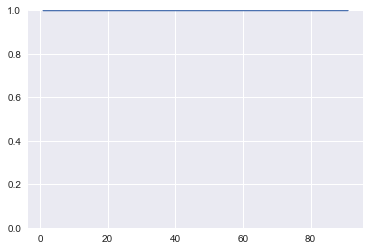

In [81]:
plt.plot(trunk_lengths, spearmanr_y)
plt.ylim([0,1])

In [82]:
EA=0
EB=0
for i in range(Graph_A.shape[0]):
    for j in range(Graph_A.shape[0]):
        EA = EA + 0.5*Graph_A[i,j]*(scores_Graph_A[i] - scores_Graph_A[j] - 1)**2
        EB = EB + 0.5*Graph_B[i,j]*(scores_Graph_B[i] - scores_Graph_B[j] - 1)**2
print(EA, EB)

4.04871661478e-24 9.86133102075e-25


Yes, energy of the two graphs are both zero! 

The estimate of beta is consistent for all trials.

Spearman correlation of the two graphs are also 1 for all trials

BUT, why is the clusetering score using just the ranking high in the middle? It definitely underfits, so many if it separate them into two groups, the completeness score is still pretty high... Let's check

In [119]:
data= np.load('y_graph_data_8-6.npz')

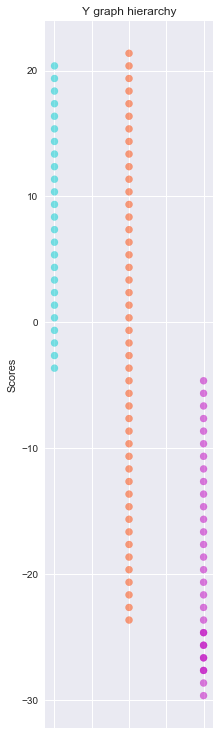

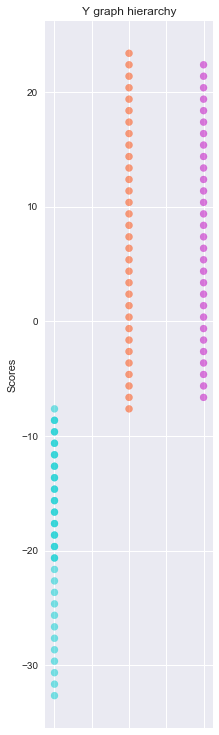

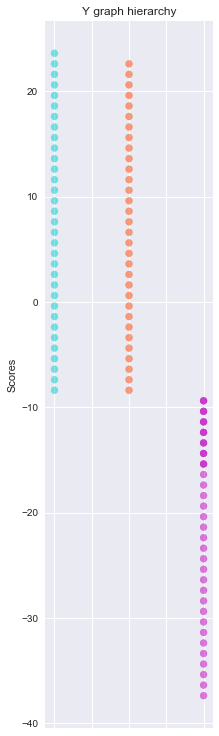

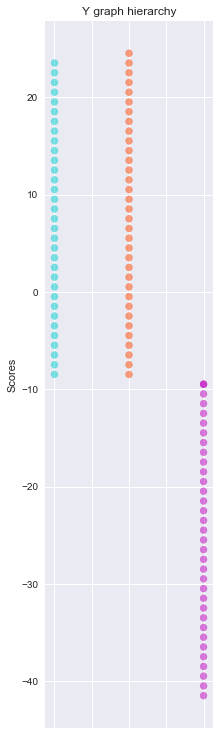

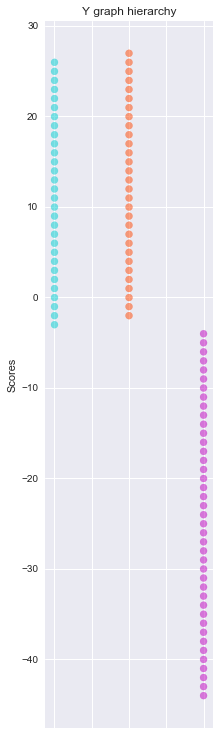

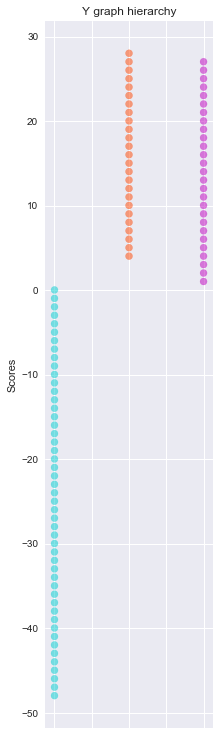

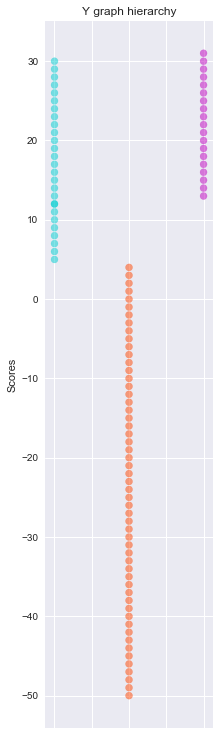

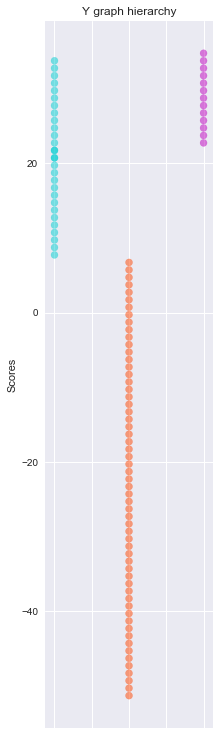

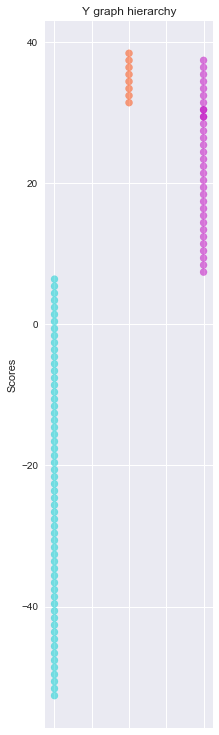

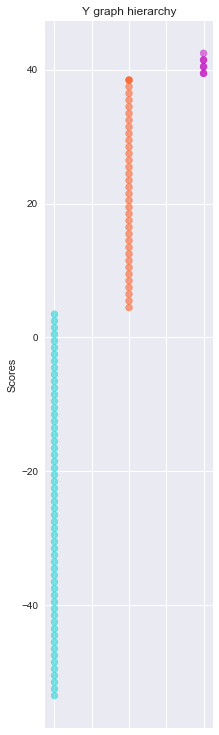

In [122]:
#Using the rankings:
colors = ['darkturquoise','orangered','m','greenyellow']
for j in range(scores_Graph_As.shape[0]):
    n_clusters=3
    #cluster
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(data['delta_correlation'][j,:,:])
    groups_pred = kmeans.labels_

    color = [ colors[i] for i in groups_pred]
    f = plt.figure(figsize=(3,13))
    plt.scatter(groups_pred, data['scores_A'][j,:] , color=color, alpha=0.5)
    plt.title('Y graph hierarchy')
    plt.ylabel('Scores')
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off') # labels along the bottom edge are off
    plt.savefig('presentation/images/y graph/cluster/clusters_delta'+str(j)+'.png')

In [129]:
#Plot density:
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
for i in range( data['scores_A'].shape[0]):
    X =  data['scores_A'][i,:][:, np.newaxis]
    X_plot = np.linspace(np.min(X), np.max(X), 1000)[:, np.newaxis]
    fig, ax = plt.subplots()
    kde = KernelDensity(kernel='gaussian', bandwidth=0.75).fit(X)
    log_dens = kde.score_samples(X_plot) 
    ax.plot(X_plot[:, 0], np.exp(log_dens), '-',
            label="kernel = '{0}'".format('gaussian'))
    plt.savefig('presentation/images/y graph/scores/scoresA_dist_trunk'+str(i)+'.png')
    plt.clf()

Three Groups
--------

In [104]:
reps = 100
n = 102
trials=10
avg_degree = 5 
beta_list = np.arange(0.1, 2.1, 0.1)
bs = beta_list.size
groups = np.concatenate((np.repeat(0, int(102/3)), np.repeat(1, int(102/3)), np.repeat(2, int(102/3))))

spearman_corel = np.zeros((bs, reps)) 

homogeneity = np.zeros((bs, reps)) #measures of quality of clusters
completeness = np.zeros((bs, reps))
vmeasure = np.zeros((bs, reps))

homogeneity_scr = np.zeros((bs, reps))
completeness_scr = np.zeros((bs, reps))
vmeasure_scr = np.zeros((bs, reps))

n_cluster_list = np.zeros((bs, reps))
n_cluster_list_scr = np.zeros((bs, reps))

correlations = np.zeros((bs,n,n))
ranks = np.zeros((bs,n))

for r in range(reps):
    #plant ranks
    scores = np.concatenate((np.random.normal(-4, math.sqrt(2), size=int(n/3)), 
                         np.random.normal(0, math.sqrt(0.5),size=int(n/3)), 
                         np.random.normal(4, math.sqrt(1), size=int(n/3))))
    #spring energy matrix
    spr = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            spr[i,j] = (scores[i] - scores[j] - 1)**2
            
    for i in range(bs):
        #plant graph
        beta = beta_list[i]
        c = avg_degree*n/np.sum(np.exp(-0.5*beta*spr))
        A = rank.generate_graph2(s=scores, beta=beta, c=c)
        
        #calculate ranks
        out = rank.spring_rank(A)
        scores_pred = out[0]
        
        #compare to planted ranks
        spearman_corel[i, r] = spearmanr(scores, scores_pred)[0]
        
        #correlation between ranks
        sigma = out[1]
        correlation = rank.pearson_correlation(sigma)
        
        if r==1:
            correlations[i,:,:] = correlation
            ranks[i,:] = scores_pred
        
        #cluster the correlation and predicted scores
        features = [correlation, scores_pred.reshape((n,1))]
        for m in range(2):
#             ss = np.zeros(trials)
#             for k in range(1,trials):
#                 #choose number of clusters using silhouette scores
#                 kmeans = KMeans(n_clusters=k+1, random_state=0).fit(features[m])
#                 ss[k] = metrics.silhouette_score(features[m], kmeans.labels_)
#             n_clusters = int(np.argmax(ss) + 1)
            n_clusters = 3
            
            #cluster:
            kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(features[m])
            groups_pred = kmeans.labels_

            #measure quality of clusters
            if m == 0:
                homogeneity[i, r] = metrics.homogeneity_score(groups, groups_pred)  
                completeness[i, r] = metrics.completeness_score(groups, groups_pred)
                vmeasure[i, r] = metrics.v_measure_score(groups, groups_pred)
                n_cluster_list[i, r] = n_clusters
            else:
                homogeneity_scr[i, r] = metrics.homogeneity_score(groups, groups_pred)  
                completeness_scr[i, r] = metrics.completeness_score(groups, groups_pred)
                vmeasure_scr[i, r] = metrics.v_measure_score(groups, groups_pred)
                n_cluster_list_scr[i, r] = n_clusters

In [105]:
#Save data:
#Source:https://stackoverflow.com/questions/25749215/save-a-numpy-matrix
np.savez('three_group_data_8-7', spearmanr=spearman_corel, crl_homogeneity=homogeneity, crl_completeness=completeness, 
         crl_vmeasure=vmeasure, scr_homogeneity=homogeneity_scr, scr_completeness=completeness_scr, scr_vmeasure=vmeasure_scr,
        n_clusters = n_cluster_list, scr_n_clusters= n_cluster_list_scr,
        correlations=correlations, ranks=ranks)

In [54]:
np.save('three_group_ranks_8-6', ranks)